# TP2 - Visión por computadora 1

Integrantes:
- Marco Joel Isidro (a1520)
- Diego Sarina (a1519)

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

## Parte 1

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque.
- Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.utils import show_img, show_imgs, get_images_from_video, show_roi_on_image, show_imgs_with_roi
from utils.video import VideoPlayer
from IPython.display import display, Image
import ipywidgets as widgets
import threading

A continuación vamos a definir la funcion `calculate_image_quality_measure` basado en el algoritmo que se visualiza en la imagen a continuación que pertenece al paper *Image Sharpness Measure for Blurred Images in Frequency Domain*

![Algoritmo Propuesto de FM](enunciado/proposed_algorithm.png)


In [5]:
# Declaración de la función `calculate_image_quality_measure` 
def calculate_image_quality_measure(image: np.ndarray) -> float:
    """
    Calcula la Medida de Calidad de Imagen (FM) basada en la Medida de Desenfoque en el Dominio de Frecuencia.
    Esta función calcula el valor FM para una imagen en escala de grises usando.

    args:
        image (np.ndarray): Input image in grayscale, represented as a 2D NumPy array.

    return:
        float: The Image Quality Measure (FM) of the input image.
        
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> fm = calculate_image_quality_measure(image)
    >>> print(f"Image Quality Measure (FM): {fm}")
    """

    # Step 1: Computar la transformada de Fourier de la imagen
    F = np.fft.fft2(image)

    # Step 2: Shift the zero-frequency component to the center of the spectrum
    Fc = np.fft.fftshift(F)

    # Step 3: Calcular el valor absoluto de la transformada de Fourier centrada
    AF = np.abs(Fc)

    # Step 4: Calcular el valor máximo de AF
    M = np.max(AF)

    # Step 5: Calcular T_H
    thres = M / 1000
    T_H = np.sum(AF > thres)

    # Step 6: Calcular la medida de calidad de imagen (FM)
    FM = T_H / (image.shape[0] * image.shape[1])

    return FM

In [6]:
# Declaro el path del video a leer
video_path = 'enunciado/focus_video.mov'

In [7]:
# Obtener imagenes del video para testeo
#get_images_from_video(video_path=video_path) # No necesito volver a correr esto


In [8]:
# Declaro referencias de imagenes con diferentes niveles de nitidez
imagen_borrosa = 'enunciado/frames/IMG_0000.jpg'
imagen_nitida = 'enunciado/frames/IMG_0092.jpg'
imagen_medio_borrosa = 'enunciado/frames/IMG_0060.jpg'
imagen_mas_nitida = 'enunciado/frames/IMG_0122.jpg'

imagenes_a_analizar = [imagen_borrosa, imagen_nitida, imagen_medio_borrosa, imagen_mas_nitida]

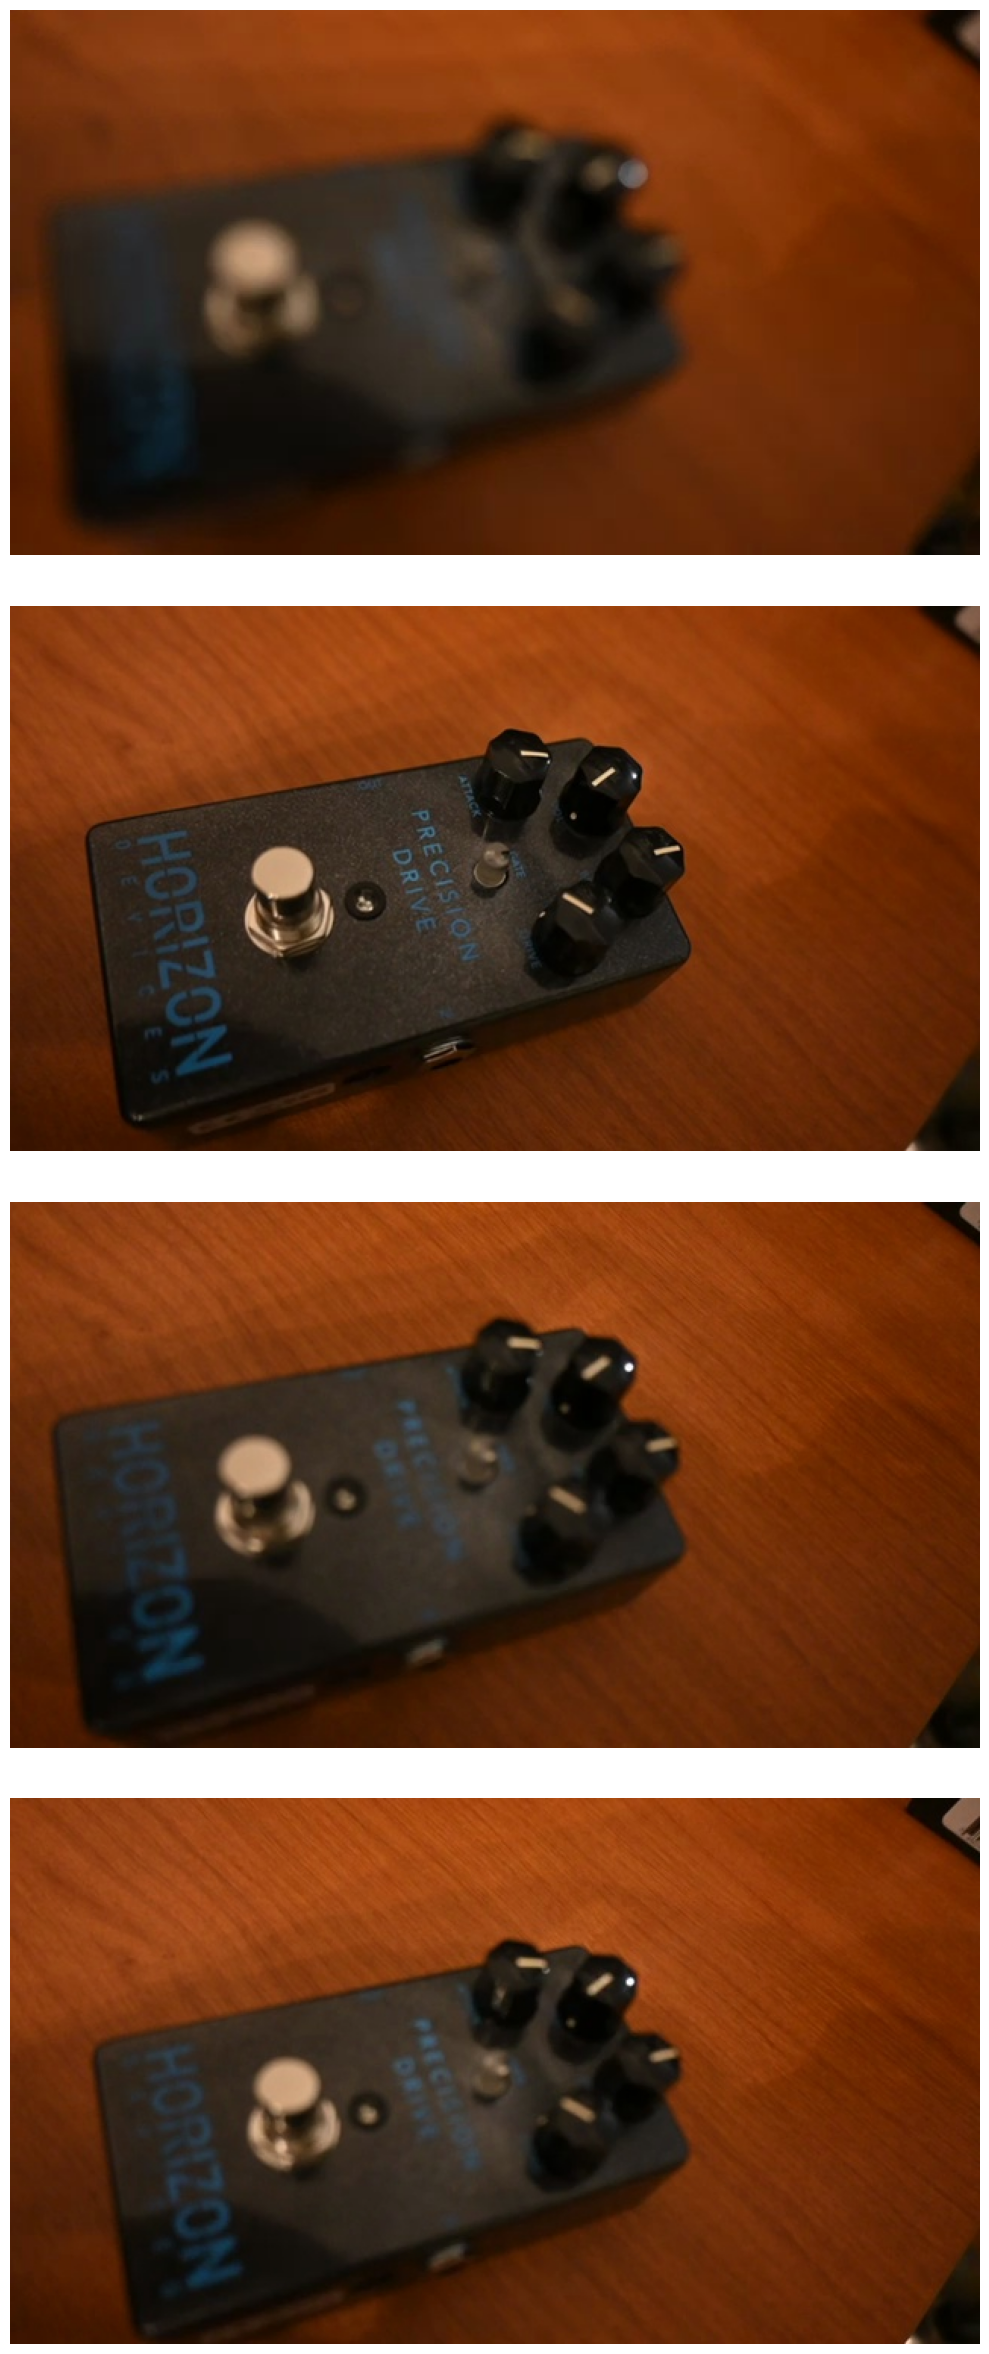

In [9]:
# Visulizo las imagenes

show_imgs(imagenes_a_analizar)

----

### Punto 1.1

- A continuación se visualiza la medición sobre todo el FRAME. Es decir que se analiza toda la imagen

In [10]:
# Calculo la metrica de enfoque para todo el frame, y para diferentes frames
image_quality_measure = [calculate_image_quality_measure(cv2.imread(i, cv2.IMREAD_GRAYSCALE)) for i in imagenes_a_analizar]

In [11]:
for i in image_quality_measure:
    print(f"Image Quality Measure (FM): {i}")

Image Quality Measure (FM): 0.0069487847222222225
Image Quality Measure (FM): 0.0266015625
Image Quality Measure (FM): 0.017951388888888888
Image Quality Measure (FM): 0.018511284722222222


NOTA: como podemos ver de la celda anterior, para el caso donde:

- FM = 0.0266015625 representa la imagen mas nitida que analizamos que se corresponde a la imagen de muestra: `enunciado/frames/IMG_0092.jpg`
- FM = 0.0069487847222222225 representa la imagen mas borrosa que analizamos que se corresponde a la imagen de muestra: `enunciado/frames/IMG_0000.jpg`

---

### Punto 1.2

- Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.

In [14]:
# Función para Medir ROI en el Centro del Frame

def calculate_roi_quality_measure(image: np.ndarray, roi_percentage:float=0.1)-> float:
    """
    Calcula la Medida de Calidad de Imagen (FM) para una región de interés (ROI) de la imagen.
    La ROI se define como un porcentaje del tamaño total de la imagen, centrada en el medio.

    args:
        image (np.ndarray): Input image in grayscale, represented as a 2D NumPy array.
        roi_percentage (float): The percentage of the image dimensions to define the ROI.
                                Default is 0.1 (10% of the image dimensions).

    return:
        float: The Image Quality Measure (FM) of the ROI of the input image.
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> fm_roi = calculate_roi_quality_measure(image, roi_percentage=0.1)
    >>> print(f"ROI Image Quality Measure (FM): {fm_roi}")
    """
    # Obtener las dimensiones de la imagen
    height, width = image.shape
    
    # Calcular las dimensiones de la ROI
    roi_height = int(height * roi_percentage)
    roi_width = int(width * roi_percentage)
    
    # Calcular las coordenadas de la ROI centrada
    y1 = height // 2 - roi_height // 2
    y2 = y1 + roi_height
    x1 = width // 2 - roi_width // 2
    x2 = x1 + roi_width
    
    # Extraer la ROI de la imagen
    roi = image[y1:y2, x1:x2]

    # Calcular la medida de calidad de imagen para la ROI
    return calculate_image_quality_measure(roi)


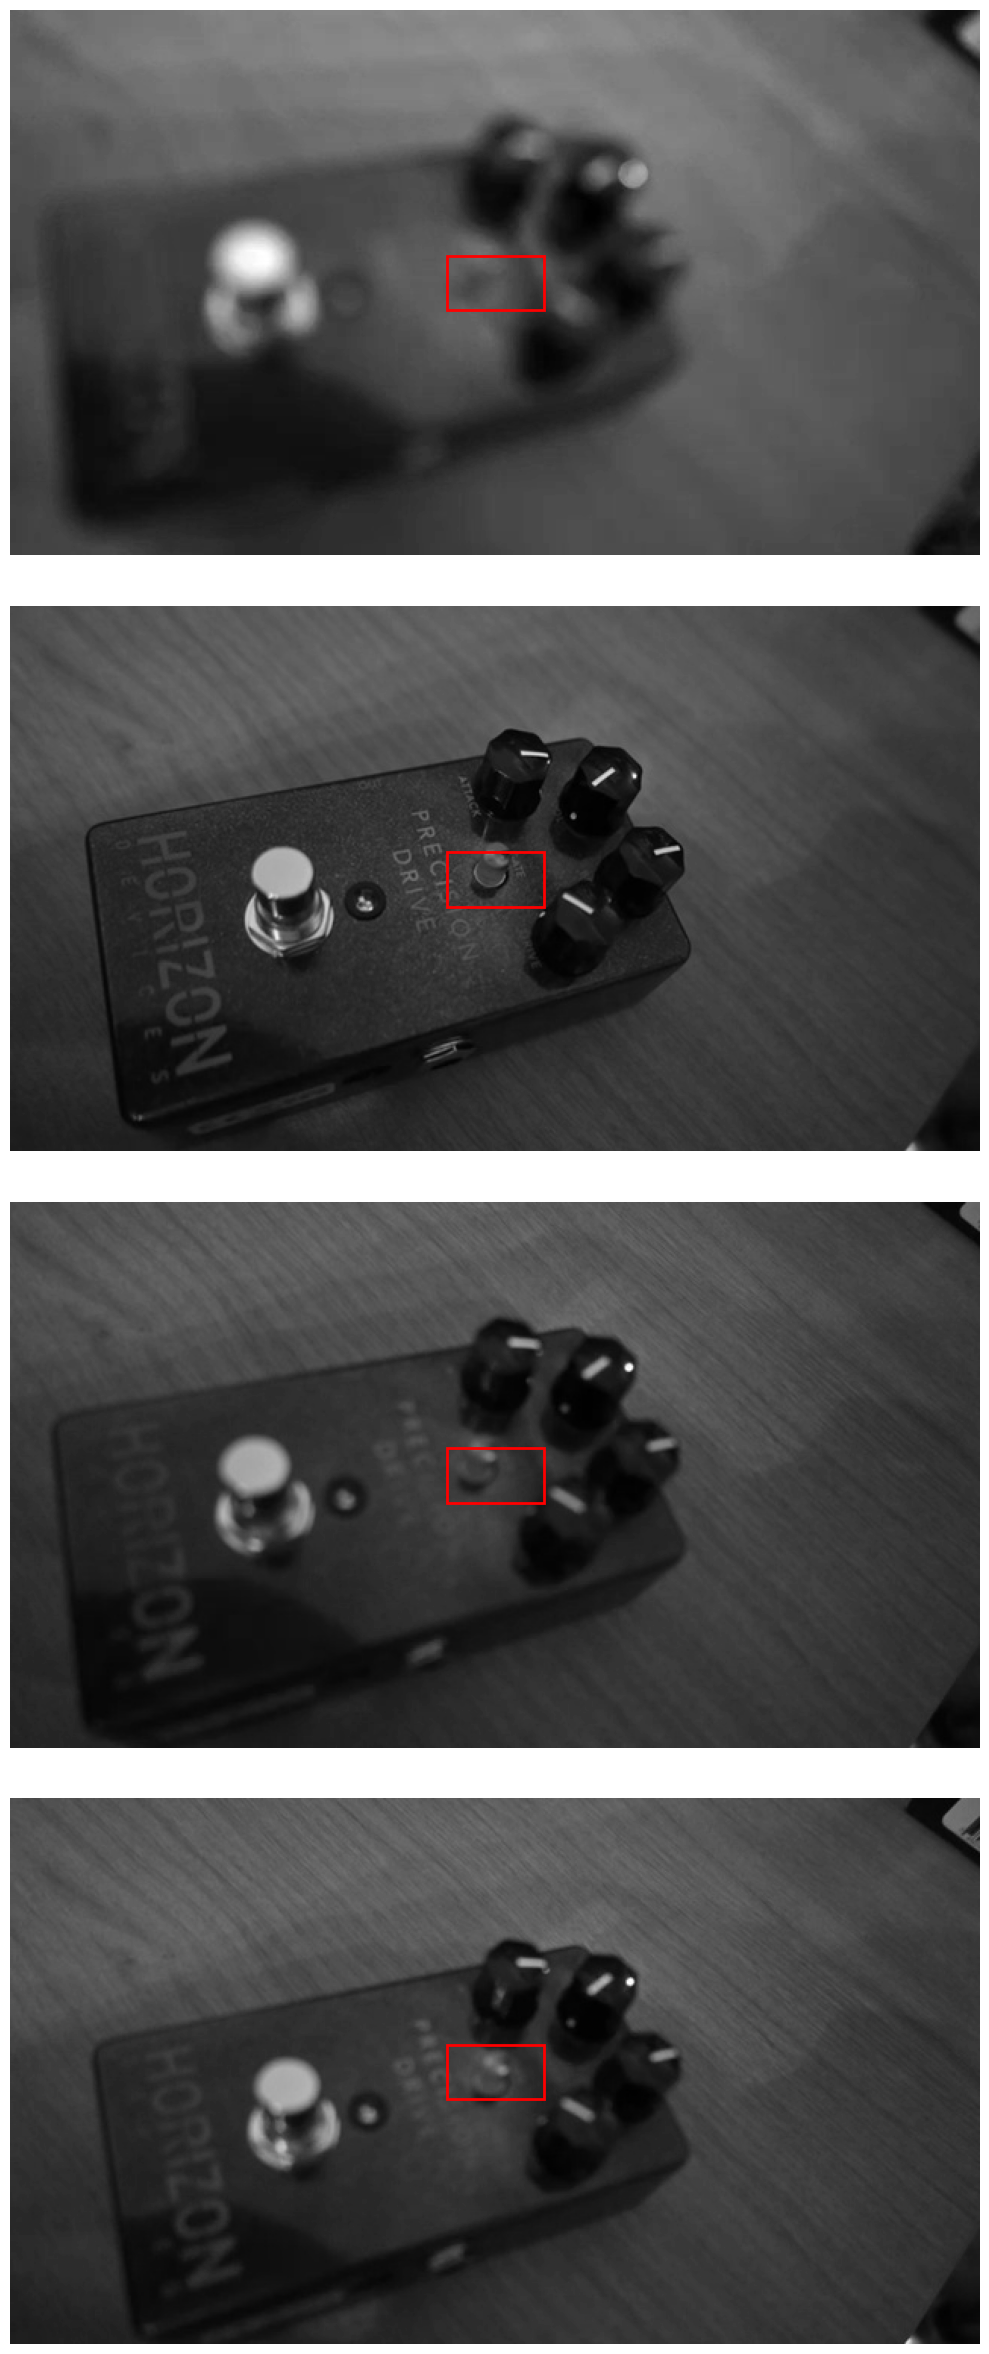

In [12]:
# Para las mismas imagenes, visulizo el roi de estas con un 10% (0.1)
show_imgs_with_roi(imagenes_a_analizar)

In [15]:
# Calculo la metrica de enfoque para las imagenes anteriores utilizando el mismo ROI que el visualizado (0.1)
image_quality_measure_ROI_01 = [calculate_roi_quality_measure(cv2.imread(i, cv2.IMREAD_GRAYSCALE)) for i in imagenes_a_analizar]

In [16]:
for i in image_quality_measure_ROI_01:
    print(f"Image Quality Measure (FM): {i}")

Image Quality Measure (FM): 0.14192708333333334
Image Quality Measure (FM): 0.6796875
Image Quality Measure (FM): 0.2287326388888889
Image Quality Measure (FM): 0.22352430555555555


----

### Punto 1.3

- Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

## Parte 2

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus. El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [2]:
video_path = 'enunciado/focus_video.mov'

In [3]:
player = VideoPlayer(video_path=video_path)


In [5]:
# cap = cv2.VideoCapture(video_path)
# cap.set(3,640) # adjust width
# cap.set(4,480) # adjust height

# while True:
#     success, img = cap.read()

#     if not success:
#         print("Failed to read frame")
#         continue  # Exit loop if frame not read properly

#     cv2.imshow("Webcam", img) # This will open an independent window
    
#     if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
#         break

# cap.release()
# cv2.destroyAllWindows() 
# cv2.waitKey(1) # normally unnecessary, but it fixes a bug on MacOS where the window doesn't close

In [6]:
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output
from threading import Thread

class VideoPlayer:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.frame_rate = self.cap.get(cv2.CAP_PROP_FPS)
        self.current_frame = 0
        self.playing = False
        self.show_info = False

        # Controles
        self.play_pause_button = widgets.Button(description="Play")
        self.next_button = widgets.Button(description="Next Frame")
        self.info_checkbox = widgets.Checkbox(value=False, description='Show Info')
        self.controls = widgets.HBox([self.play_pause_button, self.next_button, self.info_checkbox])

        # Conectar eventos
        self.play_pause_button.on_click(self.toggle_play_pause)
        self.next_button.on_click(self.next_frame)
        self.info_checkbox.observe(self.toggle_info, names='value')

    def display_controls(self):
        display(self.controls)
        self.show_frame()

    def toggle_play_pause(self, b):
        if self.playing:
            self.playing = False
            self.play_pause_button.description = "Play"
        else:
            self.playing = True
            self.play_pause_button.description = "Pause"
            Thread(target=self.play).start()

    def next_frame(self, b):
        self.playing = False
        self.play_pause_button.description = "Play"
        self.current_frame += 1
        if self.current_frame >= self.frame_count:
            self.current_frame = 0
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
        self.show_frame()

    def toggle_info(self, change):
        self.show_info = change['new']
        self.show_frame()

    def play(self):
        while self.playing:
            ret, frame = self.cap.read()
            if not ret:
                self.playing = False
                self.play_pause_button.description = "Play"
                break

            self.current_frame += 1
            if self.show_info:
                cv2.putText(frame, f'Frame: {self.current_frame}/{self.frame_count}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                elapsed_time = self.current_frame / self.frame_rate
                cv2.putText(frame, f'Time: {elapsed_time:.2f}s', (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            _, buffer = cv2.imencode('.jpg', frame)
            display_img = widgets.Image(value=buffer.tobytes(), format='jpg', width=640, height=480)
            clear_output(wait=True)
            display(self.controls)
            display(display_img)

            if cv2.waitKey(int(1000 / self.frame_rate)) & 0xFF == ord('q'):
                break

    def show_frame(self):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
        ret, frame = self.cap.read()
        if ret:
            if self.show_info:
                cv2.putText(frame, f'Frame: {self.current_frame}/{self.frame_count}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                elapsed_time = self.current_frame / self.frame_rate
                cv2.putText(frame, f'Time: {elapsed_time:.2f}s', (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            _, buffer = cv2.imencode('.jpg', frame)
            display_img = widgets.Image(value=buffer.tobytes(), format='jpg', width=640, height=480)
            clear_output(wait=True)
            display(self.controls)
            display(display_img)

In [ ]:
player = VideoPlayer(video_path)
player.display_controls()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [48]:
# Step 1 - computar imagen de fourier

import numpy as np

img_gray =cv2.imread(imagen_nitida ,cv2.IMREAD_GRAYSCALE)





In [49]:
type(img_gray)

numpy.ndarray

In [68]:
def calculate_focus_matrix_quality_measure(image, rows, cols):
    height, width = image.shape
    step_y = height // rows
    step_x = width // cols
    
    fm_values = []
    
    for i in range(rows):
        for j in range(cols):
            y1 = i * step_y
            y2 = (i + 1) * step_y
            x1 = j * step_x
            x2 = (j + 1) * step_x
            
            sub_image = image[y1:y2, x1:x2]
            fm = calculate_image_quality_measure(sub_image)
            fm_values.append(fm)
    
    return fm_values


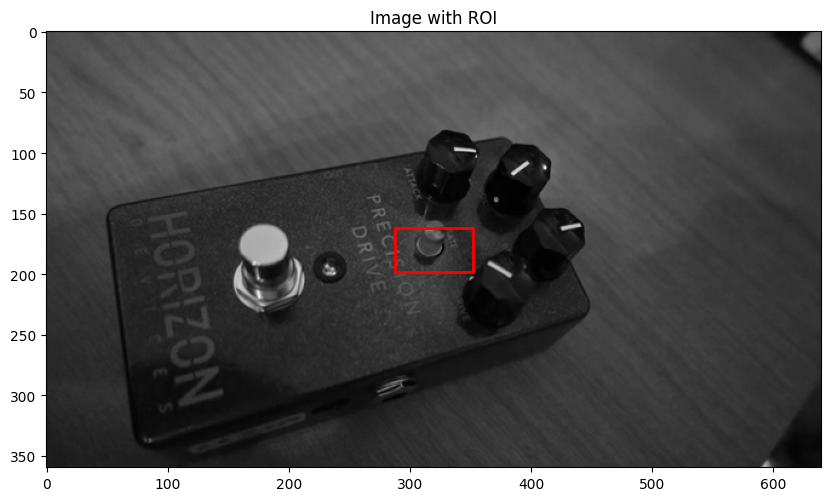

In [122]:
image = cv2.imread(imagen_nitida, cv2.IMREAD_GRAYSCALE)


show_roi_on_image(image,0.1)

In [74]:
fm = calculate_image_quality_measure(image)
print("Image Quality Measure:", fm)

Image Quality Measure: 0.0266015625


In [88]:
roi_fm = calculate_roi_quality_measure(image, roi_percentage=0.6)
print("ROI Quality Measure:", roi_fm)

ROI Quality Measure: 0.10578221450617284


In [90]:
rows, cols = 4, 4  # Puedes ajustar el número de filas y columnas
fm_matrix = calculate_focus_matrix_quality_measure(image, rows, cols)
print("Focus Matrix Quality Measures:", fm_matrix)


Focus Matrix Quality Measures: [np.float64(0.019097222222222224), np.float64(0.015347222222222222), np.float64(0.06402777777777778), np.float64(0.058125), np.float64(0.08388888888888889), np.float64(0.24833333333333332), np.float64(0.355625), np.float64(0.02763888888888889), np.float64(0.22006944444444446), np.float64(0.3252083333333333), np.float64(0.2501388888888889), np.float64(0.030694444444444444), np.float64(0.15118055555555557), np.float64(0.20527777777777778), np.float64(0.06854166666666667), np.float64(0.105)]


In [108]:
def plot_focus_matrix_on_image(image, fm_matrix, rows, cols):
    height, width = image.shape
    step_y = height // rows
    step_x = width // cols
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    # Añadir los valores de la matriz de enfoque como texto en cada subregión
    for i in range(rows):
        for j in range(cols):
            y1 = i * step_y
            y2 = (i + 1) * step_y
            x1 = j * step_x
            x2 = (j + 1) * step_x
            
            fm_value = fm_matrix[i * cols + j]
            
            # Dibujar el rectángulo
            rect = plt.Rectangle((x1, y1), step_x, step_y, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            
            # Añadir el valor del FM en el centro del rectángulo
            ax.text(x1 + step_x / 2, y1 + step_y / 2, f'{fm_value:.2f}', color='yellow', ha='center', va='center', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

    #ax.set_title('Focus Matrix Quality Measures on Image')
    plt.show()

In [105]:
# Calcular la matriz de enfoque de calidad de la imagen
rows, cols = 5, 5  # Puedes ajustar el número de filas y columnas
fm_matrix = calculate_focus_matrix_quality_measure(image, rows, cols)

In [106]:
fm_matrix

[np.float64(0.025716145833333332),
 np.float64(0.0185546875),
 np.float64(0.015082465277777778),
 np.float64(0.021158854166666668),
 np.float64(0.0978732638888889),
 np.float64(0.06944444444444445),
 np.float64(0.09071180555555555),
 np.float64(0.4000651041666667),
 np.float64(0.2574869791666667),
 np.float64(0.0390625),
 np.float64(0.17686631944444445),
 np.float64(0.3487413194444444),
 np.float64(0.4230685763888889),
 np.float64(0.2974175347222222),
 np.float64(0.03884548611111111),
 np.float64(0.1662326388888889),
 np.float64(0.3643663194444444),
 np.float64(0.2696397569444444),
 np.float64(0.12706163194444445),
 np.float64(0.037543402777777776),
 np.float64(0.2016059027777778),
 np.float64(0.20735677083333334),
 np.float64(0.22623697916666666),
 np.float64(0.048285590277777776),
 np.float64(0.17057291666666666)]

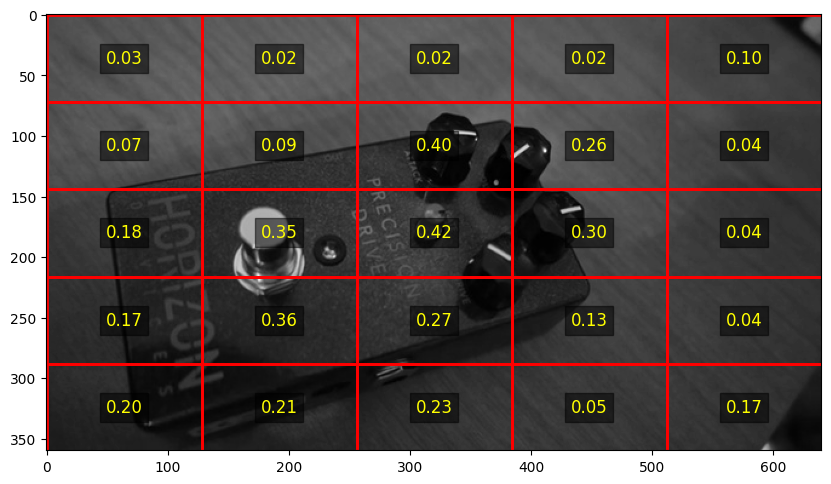

In [109]:
plot_focus_matrix_on_image(image, fm_matrix, rows, cols)


In [112]:
def plot_focus_matrix_on_image2(image, fm_matrix, rows, cols):
    height, width = image.shape
    step_y = height // rows
    step_x = width // cols
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (rows // 2) * step_y
    start_x = center_x - (cols // 2) * step_x

    # Añadir los valores de la matriz de enfoque como texto en cada subregión
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            fm_value = fm_matrix[i * cols + j]
            
            # Dibujar el rectángulo
            rect = plt.Rectangle((x1, y1), step_x, step_y, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            
            # Añadir el valor del FM en el centro del rectángulo
            ax.text(x1 + step_x / 2, y1 + step_y / 2, f'{fm_value:.2f}', color='yellow', ha='center', va='center', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

    ax.set_title('Focus Matrix Quality Measures on Image')
    plt.show()

In [114]:
def calculate_focus_matrix_quality_measure2(image, rows, cols):
    height, width = image.shape
    step_y = height // rows
    step_x = width // cols
    
    fm_values = []
    
    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (rows // 2) * step_y
    start_x = center_x - (cols // 2) * step_x
    
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            sub_image = image[y1:y2, x1:x2]
            fm = calculate_image_quality_measure(sub_image)
            fm_values.append(fm)
    
    return fm_values


In [115]:
fm_matrix = calculate_focus_matrix_quality_measure2(image, rows, cols)

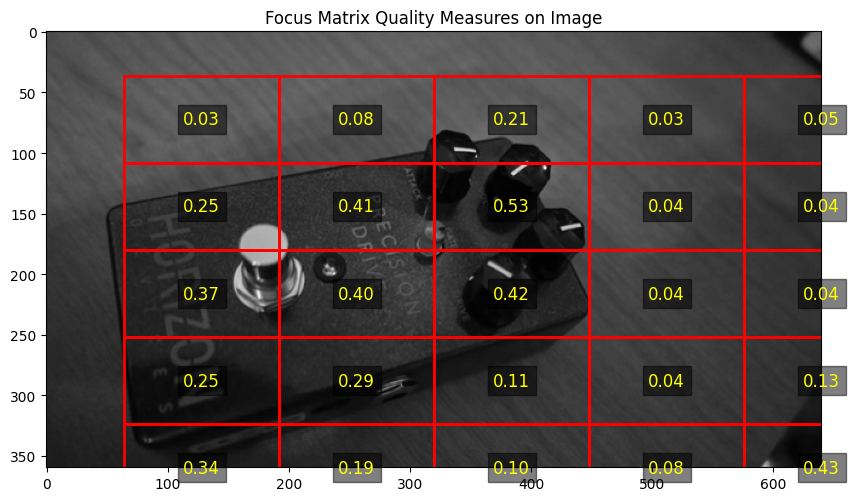

In [116]:
plot_focus_matrix_on_image2(image, fm_matrix, rows, cols)


In [117]:
def calculate_focus_matrix_quality_measure3(image, rows, cols):
    height, width = image.shape
    step_y = height // rows
    step_x = width // cols
    
    fm_values = []
    
    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (rows // 2) * step_y
    start_x = center_x - (cols // 2) * step_x
    
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            sub_image = image[y1:y2, x1:x2]
            fm = calculate_image_quality_measure(sub_image)
            fm_values.append(fm)
    
    return fm_values

def plot_focus_matrix_on_image3(image, fm_matrix, rows, cols):
    height, width = image.shape
    step_y = height // rows
    step_x = width // cols
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (rows // 2) * step_y
    start_x = center_x - (cols // 2) * step_x

    # Añadir los valores de la matriz de enfoque como texto en cada subregión
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            fm_value = fm_matrix[i * cols + j]
            
            # Dibujar el rectángulo
            rect = plt.Rectangle((x1, y1), step_x, step_y, edgecolor='green', facecolor='none', linewidth=1)
            ax.add_patch(rect)
            
            # Añadir el valor del FM en el centro del rectángulo
            ax.text(x1 + step_x / 2, y1 + step_y / 2, f'{fm_value:.2f}', color='yellow', ha='center', va='center', fontsize=6, bbox=dict(facecolor='black', alpha=0.5))

    ax.set_title('Focus Matrix Quality Measures on Image')
    plt.show()

In [118]:
image

array([[ 72,  72,  73, ..., 102, 102, 101],
       [ 73,  74,  74, ..., 101, 101, 101],
       [ 75,  75,  75, ..., 101, 101, 102],
       ...,
       [ 28,  28,  28, ...,  14,  14,  14],
       [ 28,  28,  28, ...,  14,  14,  14],
       [ 28,  28,  28, ...,  14,  14,  14]], dtype=uint8)

In [119]:
rows, cols = 7, 7

In [120]:
fm_matrix = calculate_focus_matrix_quality_measure3(image, rows, cols)


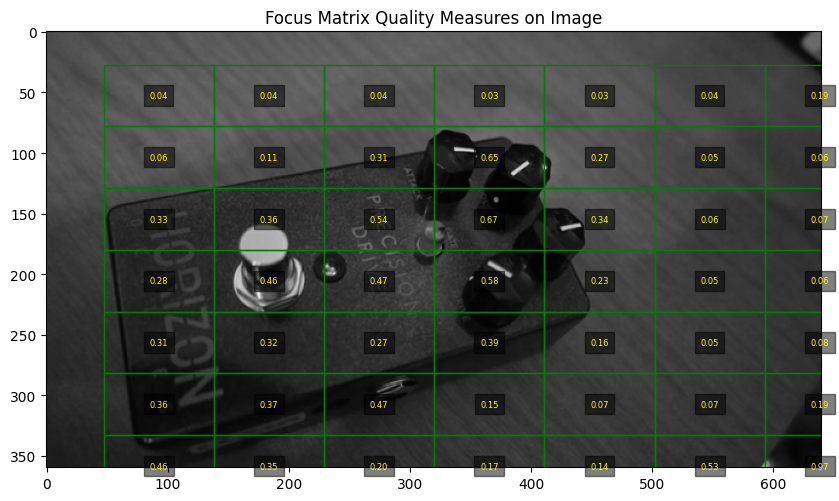

In [121]:
plot_focus_matrix_on_image3(image, fm_matrix, rows, cols)


In [123]:
def calculate_focus_matrix_quality_measure4(image, rows, cols, scale_factor=1.0):
    height, width = image.shape
    
    # Calcular el tamaño ajustado de la grilla basado en el factor de escala
    scaled_height = int(height * scale_factor)
    scaled_width = int(width * scale_factor)
    
    step_y = scaled_height // rows
    step_x = scaled_width // cols
    
    fm_values = []
    
    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (scaled_height // 2)
    start_x = center_x - (scaled_width // 2)
    
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            sub_image = image[y1:y2, x1:x2]
            fm = calculate_image_quality_measure(sub_image)
            fm_values.append(fm)
    
    return fm_values

def plot_focus_matrix_on_image4(image, fm_matrix, rows, cols, scale_factor=1.0):
    height, width = image.shape
    
    # Calcular el tamaño ajustado de la grilla basado en el factor de escala
    scaled_height = int(height * scale_factor)
    scaled_width = int(width * scale_factor)
    
    step_y = scaled_height // rows
    step_x = scaled_width // cols
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (scaled_height // 2)
    start_x = center_x - (scaled_width // 2)

    # Añadir los valores de la matriz de enfoque como texto en cada subregión
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            fm_value = fm_matrix[i * cols + j]
            
            # Dibujar el rectángulo
            rect = plt.Rectangle((x1, y1), step_x, step_y, edgecolor='green', facecolor='none', linewidth=1)
            ax.add_patch(rect)
            
            # Añadir el valor del FM en el centro del rectángulo
            ax.text(x1 + step_x / 2, y1 + step_y / 2, f'{fm_value:.2f}', color='yellow', ha='center', va='center', fontsize=6, bbox=dict(facecolor='black', alpha=0.5))

    ax.set_title('Focus Matrix Quality Measures on Image')
    plt.show()

In [134]:
fm_matrix = calculate_focus_matrix_quality_measure4(image, rows, cols, 0.7)

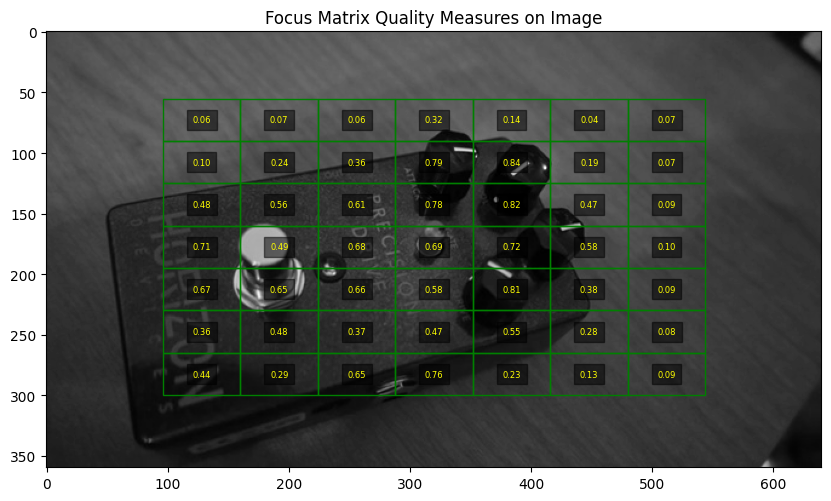

In [137]:
plot_focus_matrix_on_image4(image, fm_matrix, rows, cols, 0.7)


# Parte extra

Aplicar unsharp masking para expandir la zona de enfoque y devolver.